# Reinforced learning, työllistyminen ja Suomen sosiaaliturva

Tässä tehdään laskelmat artikkelia varten. Käytössä on gym-ympäristö _unemployment-v1_ , johon on toteutettu yksityiskohtaisempi työttömyysturvamalli.

In [1]:
# for Colab, install fin_benefits and unemployment-gym from Github
#!pip install -q git+https://github.com/ajtanskanen/benefits.git  
#!pip install -q git+https://github.com/ajtanskanen/econogym.git
#!pip install -q git+https://github.com/ajtanskanen/lifecycle-rl.git

# and then restart kernel
  
  # For a specific version:
#!pip install tensorflow==1.15
#!pip install stable-baselines==2.8
  
# restart kernel after running pip's

Then load all modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lifecycle_rl import Lifecycle

%matplotlib inline
%pylab inline

# varoitukset piiloon (Stable baseline ei ole vielä Tensorflow 2.0-yhteensopiva, ja Tensorflow 1.5 valittaa paljon)
import warnings
warnings.filterwarnings('ignore')

pop_size=1_000

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Populating the interactive namespace from numpy and matplotlib


# Nykymalli 

Lasketaan työllisyysasteet nykymallissa.

In [2]:
cc1=Lifecycle(env='unemployment-v1',minimal=False,mortality=True,perustulo=False,randomness=True,deterministic=False)
cc1.explain()
cc1.train(steps=10_000_000,cont=True,rlmodel='acktr',save='perusmalli_0',batch=1,debug=True,bestname='best_perus')

Mortality included, stopped
Parameters of lifecycle:
timestep 0.25
gamma 0.9793703613355593 (0.9200000000000003 per anno)
min_age 20
max_age 70
min_retirementage 65
max_retirementage 70
ansiopvraha_kesto300 None
ansiopvraha_kesto400 None
ansiopvraha_toe None
perustulo False
karenssi_kesto 0.25
mortality True
randomness True
deterministic False

use_vecmonitor True
use_callback False
init vecmonitor:  tmp/vecmonitor.json
init resultswriter




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






training...






----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 173.49684 |
| explained_variance | 0.936     |
| fps                | 139       |
| nupdates           | 1         |
| policy_entropy     | 0.501     |
| policy_loss        | 1.46      |
| total_timestep

----------------------------------
| ep_len_mean        | 195       |
| ep_reward_mean     | 209.15312 |
| explained_variance | -0.156    |
| fps                | 339       |
| nupdates           | 600       |
| policy_entropy     | 0.0433    |
| policy_loss        | -0.763    |
| total_timesteps    | 123394    |
| value_loss         | 113       |
----------------------------------
----------------------------------
| ep_len_mean        | 193       |
| ep_reward_mean     | 206.40097 |
| explained_variance | 0.444     |
| fps                | 340       |
| nupdates           | 700       |
| policy_entropy     | 0.171     |
| policy_loss        | -1.88     |
| total_timesteps    | 143994    |
| value_loss         | 151       |
----------------------------------
----------------------------------
| ep_len_mean        | 195       |
| ep_reward_mean     | 205.60611 |
| explained_variance | 0.985     |
| fps                | 341       |
| nupdates           | 800       |
| policy_entropy    

KeyboardInterrupt: 

In [ ]:
cc1.simulate(pop=10_000,deterministic=False,load='tmp/best_perus',rlmodel='acktr',save='perusmalli')

# EK:n malli

Lasketaan vertailukelpoiset työllisyysasteet EK:n ehdottamalla mallilla. Mallissa on toteuttu muutoksia ansiosidonnaiseen työttömyysturvaan, asumistukeen, toimeentulotukeen ja verotukseen.

In [5]:
cc2=Lifecycle(env='unemploymentEK-v1',minimal=False,mortality=True,perustulo=False,randomness=True)
cc2.train(steps=10_000_000,cont=False,rlmodel='acktr',save='ekn_malli',batch=1,start_from='tmp/best_perus',bestname='best_ek',debug=True)
cc2.simulate(pop=10_000,deterministic=False,load='tmp/best_ek',rlmodel='acktr',save='eknmalli')

Mortality included, stopped
training...
215186 timesteps
Best mean reward: -inf - Last mean reward per episode: 197.10
Saving new best model
225344 timesteps
Best mean reward: 197.10 - Last mean reward per episode: 197.34
Saving new best model
235674 timesteps
Best mean reward: 197.34 - Last mean reward per episode: 198.00
Saving new best model
245964 timesteps
Best mean reward: 198.00 - Last mean reward per episode: 198.28
Saving new best model
256214 timesteps
Best mean reward: 198.28 - Last mean reward per episode: 198.71
Saving new best model
266465 timesteps
Best mean reward: 198.71 - Last mean reward per episode: 199.17
Saving new best model
276643 timesteps
Best mean reward: 199.17 - Last mean reward per episode: 199.41
Saving new best model
286898 timesteps
Best mean reward: 199.41 - Last mean reward per episode: 199.92
Saving new best model
297099 timesteps
Best mean reward: 199.92 - Last mean reward per episode: 200.87
Saving new best model
307453 timesteps
Best mean reward: 

1158146 timesteps
Best mean reward: 210.85 - Last mean reward per episode: 209.62
1168394 timesteps
Best mean reward: 210.85 - Last mean reward per episode: 209.99
1178640 timesteps
Best mean reward: 210.85 - Last mean reward per episode: 209.74
1188941 timesteps
Best mean reward: 210.85 - Last mean reward per episode: 209.81
1199117 timesteps
Best mean reward: 210.85 - Last mean reward per episode: 210.02
1209404 timesteps
Best mean reward: 210.85 - Last mean reward per episode: 210.34
1219635 timesteps
Best mean reward: 210.85 - Last mean reward per episode: 210.63
1229821 timesteps
Best mean reward: 210.85 - Last mean reward per episode: 209.92
1240125 timesteps
Best mean reward: 210.85 - Last mean reward per episode: 210.41
1250471 timesteps
Best mean reward: 210.85 - Last mean reward per episode: 210.04
1260738 timesteps
Best mean reward: 210.85 - Last mean reward per episode: 209.68
1270931 timesteps
Best mean reward: 210.85 - Last mean reward per episode: 209.15
1281234 timestep

2172872 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 209.48
2183151 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 209.45
2193474 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 210.02
2203662 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 210.16
2213867 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 210.20
2224063 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 209.99
2234366 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 209.84
2244559 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 209.42
2254975 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 209.33
2265242 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 209.36
2275410 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 209.32
2285746 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 209.17
2295963 timestep

3197962 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 210.40
3208094 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 210.08
3218432 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 210.89
3228564 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 210.76
3238970 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 210.92
3249222 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 210.73
3259447 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 211.34
3269564 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 211.44
3279962 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 211.15
3290100 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 211.55
3300477 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 211.09
3310632 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 211.01
3320822 timestep

4222906 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 210.45
4233139 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 210.45
4243351 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 210.19
4253658 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 209.88
4263808 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 210.17
4274140 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 210.41
4284433 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 210.72
4294682 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 210.85
4304902 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 210.30
4315139 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 209.98
4325326 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 210.20
4335721 timesteps
Best mean reward: 212.00 - Last mean reward per episode: 209.46
4345820 timestep

5247947 timesteps
Best mean reward: 212.20 - Last mean reward per episode: 209.80
5258151 timesteps
Best mean reward: 212.20 - Last mean reward per episode: 209.98
5268473 timesteps
Best mean reward: 212.20 - Last mean reward per episode: 209.93
5278624 timesteps
Best mean reward: 212.20 - Last mean reward per episode: 209.49
5288913 timesteps
Best mean reward: 212.20 - Last mean reward per episode: 209.12
5299241 timesteps
Best mean reward: 212.20 - Last mean reward per episode: 209.05
5309445 timesteps
Best mean reward: 212.20 - Last mean reward per episode: 209.03
5319681 timesteps
Best mean reward: 212.20 - Last mean reward per episode: 208.57
5329816 timesteps
Best mean reward: 212.20 - Last mean reward per episode: 208.67
5340247 timesteps
Best mean reward: 212.20 - Last mean reward per episode: 209.29
5350456 timesteps
Best mean reward: 212.20 - Last mean reward per episode: 209.63
5360568 timesteps
Best mean reward: 212.20 - Last mean reward per episode: 210.58
5370855 timestep

6272862 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 207.64
6283137 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 207.69
6293357 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 207.03
6303699 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 208.21
6313856 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 207.82
6324092 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 207.40
6334325 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 207.49
6344595 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 207.36
6354873 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 207.67
6365079 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 207.64
6375355 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 208.24
6385635 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 208.14
6395803 timestep

7297919 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 207.49
7308097 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 207.70
7318396 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 207.87
7328555 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 208.17
7338823 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 208.17
7349234 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 207.62
7359440 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 207.81
7369555 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 208.08
7379836 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 208.06
7390055 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 208.46
7400307 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 208.05
7410652 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 207.89
7420876 timestep

8322911 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 211.73
8333196 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 211.62
8343301 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 211.60
8353741 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 211.18
8364000 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 211.61
8374170 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 211.81
8384385 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 212.01
8394565 timesteps
Best mean reward: 212.23 - Last mean reward per episode: 212.34
Saving new best model
8404897 timesteps
Best mean reward: 212.34 - Last mean reward per episode: 212.70
Saving new best model
8415120 timesteps
Best mean reward: 212.70 - Last mean reward per episode: 212.55
8425451 timesteps
Best mean reward: 212.70 - Last mean reward per episode: 212.18
8435561 timesteps
Best mean reward: 212.70 - Last mean

KeyboardInterrupt: 

predicting...


done


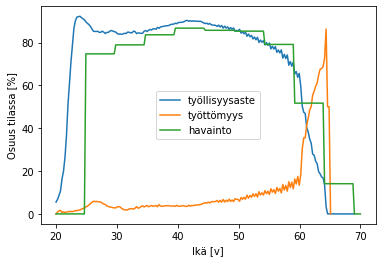

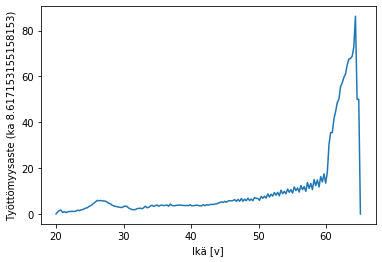

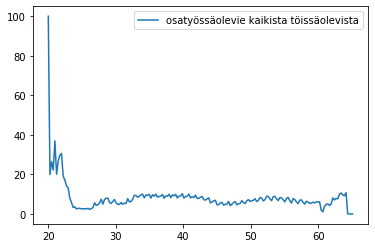

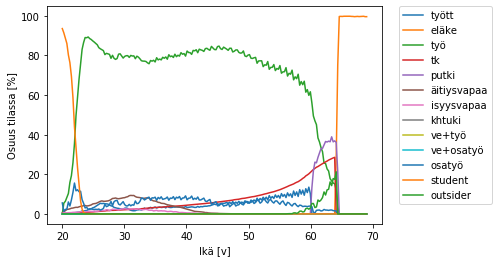

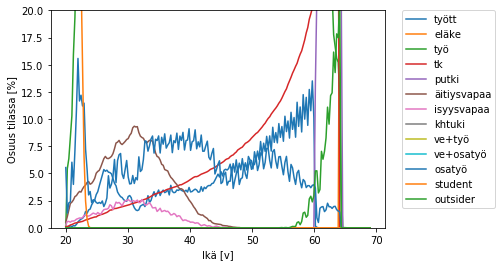

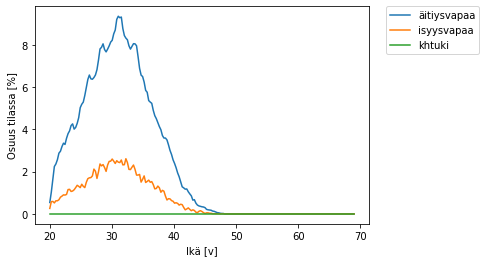

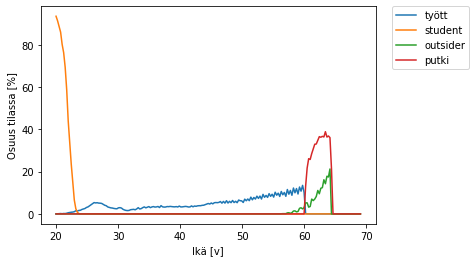

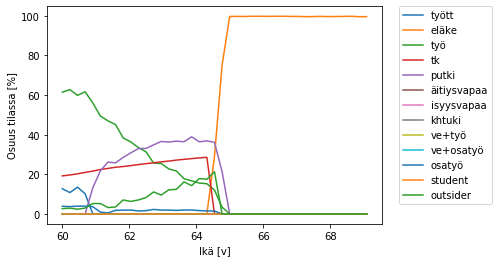

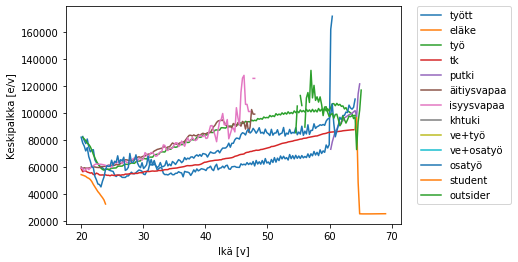

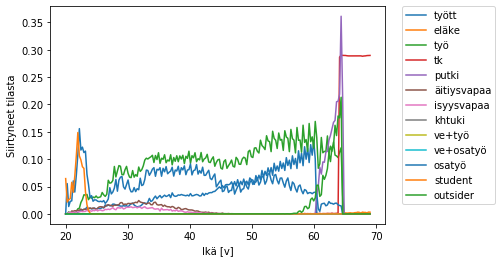

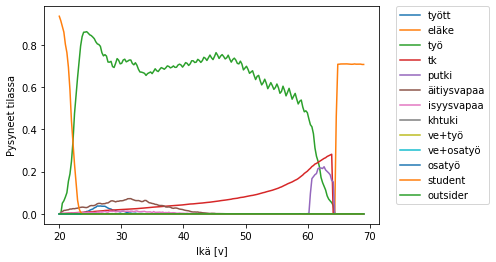

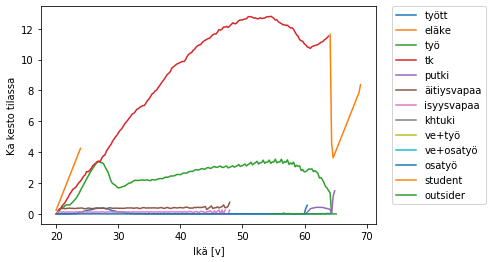

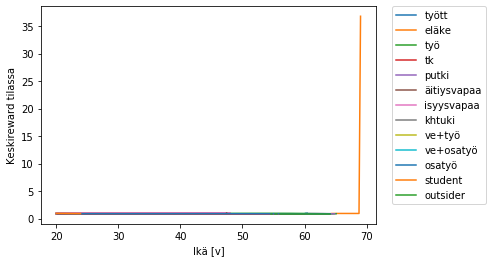

No handles with labels found to put in legend.


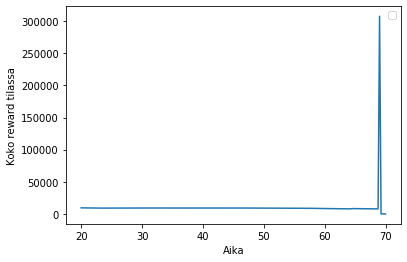

Yhteensä reward 208.75824845044295


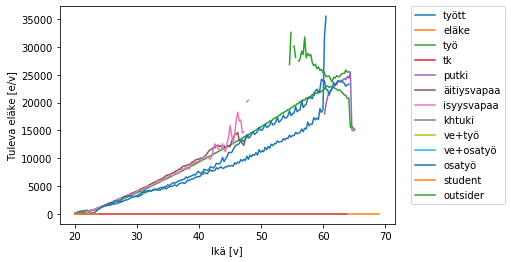

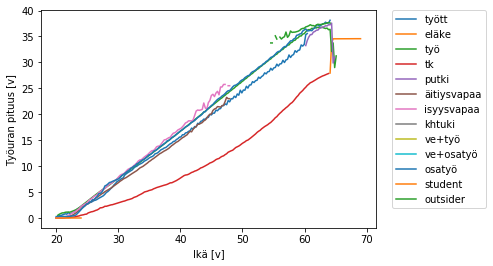

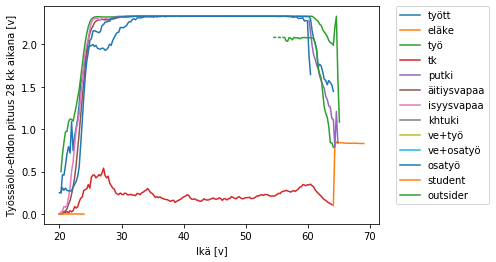

BrokenPipeError: [Errno 32] Broken pipe

In [8]:
cc1.simulate(pop=10_000,deterministic=True,load='best/best_perus',rlmodel='acktr',save='perusmalli',modify_load=False)
cc2.simulate(pop=10_000,deterministic=True,load='best/best_ek',rlmodel='acktr',save='eknmalli',modify_load=False)
cc2.compare_with(cc1)

# Verifiointi

Ajetaan sama simulaatio kaksi kertaa ja tarkastetaan että tulokset ovat sama. Tässä ideana on varmistaa, että satunnaisuus ei sotke tulosten arviointia.

In [ ]:
min_pop=1_00
cc1=Lifecycle(env='unemployment-v1',minimal=False,mortality=False,perustulo=False,randomness=False)
cc1.simulate(pop=min_pop,rlmodel='acktr',load='perusmalli_0',plot=False,debug=True)
cc10=Lifecycle(env='unemployment-v1',minimal=False,mortality=False,perustulo=False,randomness=False)
cc10.simulate(pop=min_pop,rlmodel='acktr',load='perusmalli_0',plot=False,debug=True)
cc10.compare_with(cc1)

In [ ]:
cc10=Lifecycle(env='unemployment-v1',minimal=False,mortality=False,perustulo=False,randomness=False)
cc10.simulate(pop=2000,rlmodel='acktr',load='perusmalli_0',plot=True,debug=False,deterministic=False)
cc10.compare_with(cc1)

In [ ]:
cc0=Lifecycle(env='unemployment-v1',minimal=False,mortality=False,perustulo=False,randomness=False)
cc0.distribution(n=50,steps1=1_000_000,steps2=1_000_000,pop=1_000,debug=False)

# 300 vs 400 päivän kesto ansiosidonnaisessa

Mikä on alle kolmen vuoden työhistorian lyhyemmän (300 pv) ansiosidonnaisen päivärahan enimmäiskeston vaikutus työllisyyteen? Kokeillaan miten työllisyyteen vaikuttaisi sen pidentäminen 400 päivään.

In [ ]:
cc1_400=Lifecycle(env='unemployment-v1',minimal=False,ansiopvraha_kesto300=400,randomness=False)
cc1_400.train(steps=2_000_000,cont=False,rlmodel='acktr',save='300_vs_400',start_from='perusmalli_0')
cc1_400.simulate(pop=pop_size)
cc1_400.compare_with(cc1)

# Työssäoloehdon pituus 12 kk

Entä jos työssäoloehto olisikin 12 kuukautta pitkä nykyisen 6 kuukauden sijaan?

In [ ]:
cc1_toe=Lifecycle(env='unemployment-v1',minimal=False,ansiopvraha_toe=1.0,randomness=False)
cc1_toe.train(steps=2_000_000,cont=False,rlmodel='acktr',save='toe_12',batch=1,start_from='perusmalli_0')
cc1_toe.simulate(pop=pop_size)

In [ ]:
cc_vert=Lifecycle(env='unemployment-v1',minimal=False)
cc_vert.load_sim('perusmalli_0')
cc1_toe.compare_with(cc_vert)

# Ansiosidonnaisen päivärahan lyhennys 50 pv

Tarkastellaan, miten työllisyyteen vaikuttaisi ansiosidonnaisen päivärahan lyhentäminen 50 päivällä. Tällöin alle kolmen vuoden työhistorialla ansiosidonnaisen päivärahan enimmäiskesto olisi 250 pv ja pidemmällä työhistorialla enimmäiskesto olisi 350 pv.

In [ ]:
cc1_350=Lifecycle(env='unemployment-v1',minimal=False,ansiopvraha_kesto300=250,ansiopvraha_kesto400=350,randomness=False)
cc1_350.train(train=True,steps=2_000_000,cont=False,rlmodel='acktr',save='50_short',start_from='perusmalli_0')
cc1_350.simulate(pop=pop_size)

In [ ]:
cc1_350.compare_with(cc1)

# Perustulo

In [ ]:
cc1_350=Lifecycle(env='unemployment-v1',minimal=False,perustulo=True,randomness=False)
cc1_350.train(train=True,steps=2_000_000,cont=False,rlmodel='acktr',save='perustulo',start_from='perusmalli_0')
cc1_350.simulate(pop=pop_size)

In [ ]:
cc2.compare_with(cc1)

# Protokolla-ajot

Etsitään parhaat sovitteet run_results:illa ajamalla mallia kolmessa vaiheessa:
- Ensin ajetaan sovitetta steps1 askelta
- seuraavaksi ajetaan sovitetta steps2 askelta niin että paras malli aina talletetaan (p.o. batch2==pop!)
- lopuksi testataan sovitetta ajamalla se yli populaation

In [2]:
cc=Lifecycle(env='unemployment-v1',timestep=0.25,randomness=True,mortality=False)
cc.run_results(debug=False,steps1=5_000_000,steps2=5_000_000,n=0,pop=1_000,deterministic=False,\
               train=True,predict=True,batch1=1,batch2=1000)

No mortality included
train...
phase 1
use_vecmonitor False
use_callback False


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
ccp=Lifecycle(env='unemployment-v1',timestep=0.25,randomness=True,mortality=False)
ccp.run_results(debug=False,steps1=10_000_000,steps2=5_000_000,n=0,pop=1_000,deterministic=False,\
               train=True,predict=True,batch1=1,batch2=1000)

In [ ]:
ccp1=Lifecycle(env='unemploymentEK-v1',timestep=0.25,randomness=True,mortality=False)
ccp1.run_results(debug=False,steps1=10_000_000,steps2=5_000_000,n=0,pop=1_000,deterministic=False,\
               train=True,predict=True,batch1=1,batch2=1000)